# Import Packages

In [1]:
# Import required packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
import os
os.listdir("test_images/")

['Challenge_image1.jpg',
 'Challenge_image2.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

# Read an image

X: 1280 Y: 720
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


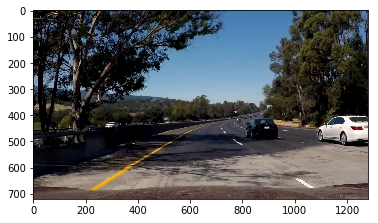

In [3]:
# Read image
image = mpimg.imread('test_images/Challenge_image1.jpg')

# Grab the x and y size 
ysize = image.shape[0]
xsize = image.shape[1]
print('X:',xsize,'Y:',ysize)
    
# Print stats and plot
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

# Convert to HSL image and filter colors 

In [4]:
# Tried color filtering in a grayscale and Hue-Saturation-Value(HSV) image but best results where obtained 
# when yellow and white colors were color filtered from Hue-Saturation-Light(HSL) image
def convertToHSL(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

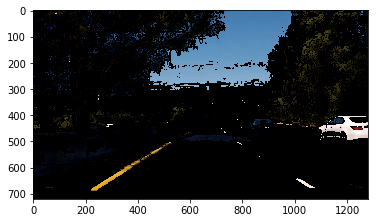

In [5]:
def filterWhiteYellow(image):
    # Make a copy of the original image
    image_initial = np.copy(image)
    imageHSL = convertToHSL(image_initial)
    
    # white color mask - High Light value for white color
    white_lower = np.uint8([ 0, 190, 0])
    white_upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(imageHSL, white_lower, white_upper)
    
    # yellow color mask - Chose 150 for Hue and 155 for Saturation to detect yellow color in all conditions
    yellow_lower = np.uint8([ 0, 0, 100])
    yellow_upper = np.uint8([ 150, 255, 255])
    yellow_mask = cv2.inRange(imageHSL, yellow_lower, yellow_upper)
    
    # combine the mask
    mask_combined = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask_combined)
    return masked_image

# Display the image 
filterImage = filterWhiteYellow(image)
plt.imshow(filterImage)

# Convert to grayscale image 

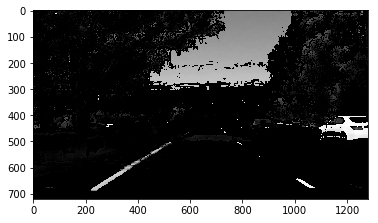

In [6]:
def grayscale(image):       
    #Convert image to grayscale
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 

# Display the image 
grayImage = grayscale(filterImage)
plt.imshow(grayImage, cmap='Greys_r')   

# Gaussian Blur and Canny edge detection

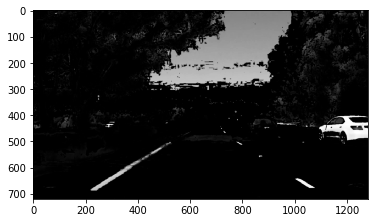

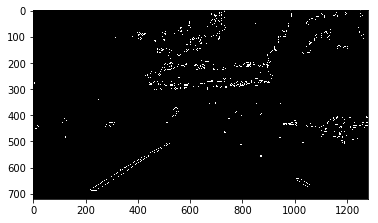

In [7]:
def gaussianBlur(image, kernel_size):
    # Apply a Gaussian Noise kernel
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def canny(image, low_threshold, high_threshold):
    # Apply Canny transform
    return cv2.Canny(image, low_threshold, high_threshold)

# Display the image 
low_threshold = 50
high_threshold = 150
kernel_size = 7

blurImage = gaussianBlur(grayImage, kernel_size)
plt.imshow(blurImage, cmap='Greys_r')
plt.show()

edgeImage= canny(blurImage, low_threshold, high_threshold)
plt.imshow(edgeImage, cmap='Greys_r')

# Region of interest

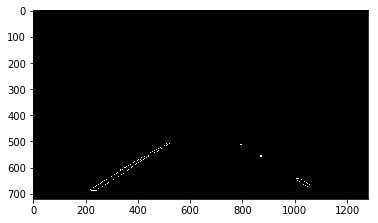

In [8]:
def regionOfInterest(image, vertices):
    # Defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# Display the image 
# Define the polygon by vertices
bottomLeft  = [0, ysize]
topLeft     = [xsize*0.45, ysize*0.6]
topRight    = [xsize*0.5, ysize*0.6] 
bottomRight = [xsize, ysize]
vertices = np.array([[bottomLeft, topLeft, topRight, bottomRight]], dtype=np.int32)

#Top endpoint of ROI on the Y axis
yLimit = int(ysize*0.6) 
    
ROIImage = regionOfInterest(edgeImage,vertices)
plt.imshow(ROIImage, cmap='Greys_r')

# Hough Transform

In [9]:
def houghLaneLines(image, rho, theta, threshold, min_line_len, max_line_gap):
    # Apply Hough transform
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

# Average hough lines and draw lane lines with lane fill

In [10]:
def average(lines):
    
    # slope,intercept,length
    leftLane = np.empty([1,3])  
    rightLane = np.empty([1,3]) 
    
    # Calculate slope, intercept and length for each hough line
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            
            # sSeparate lines into left lane and right lane lines based on the slope
            if slope < 0 and length > 50:
                leftLane = np.append(leftLane,np.array([[slope, intercept, length]]),axis = 0)
            elif slope > 0 and length > 50:
                rightLane = np.append(rightLane,np.array([[slope, intercept, length]]),axis = 0)
    
    # Weighted average of the slopes and intercepts based on the length of the line 
    leftLine = np.dot(leftLane[1:,2],leftLane[1:,:2])/np.sum(leftLane[1:,2]) if len(leftLane[1:,2]) > 0 else None
    rightLine = np.dot(rightLane[1:,2],rightLane[1:,:2])/np.sum(rightLane[1:,2]) if len(rightLane[1:,2]) > 0 else None
    
    return leftLine, rightLine

In [11]:
def findEndpoints(image, intercepts, yLimit):

    imshape = image.shape 
    
    # Store the previous left and right lane values and use these values if a NONE case is encountered in the current frame
    global prev_leftLaneLine 
    global prev_rightLaneLine 
    
    # If no NONE value is found in left and right lanes, then find the endpoints of the left and right lane to be drawn
    if None not in intercepts:
        prev_leftLaneLine = intercepts[0]
        prev_rightLaneLine = intercepts[1]      
        
        leftIntercept = intercepts[0][1]
        leftSlope = intercepts[0][0]
        rightIntercept = intercepts[1][1]
        rightSlope = intercepts[1][0]
        
        left_y1 = image.shape[0]
        left_x1 = int((left_y1 - leftIntercept) / leftSlope)

        left_y2 = yLimit
        left_x2 = int((left_y2 - leftIntercept) / leftSlope)

        right_y1 = image.shape[0]
        right_x1 = int((right_y1 - rightIntercept) / rightSlope)

        right_y2 = yLimit
        right_x2 = int((right_y2 - rightIntercept) / rightSlope)
        
        leftLaneLine = [np.int(left_x1), np.int(left_y1), np.int(left_x2), np.int(left_y2)]  
        rightLaneLine = [np.int(right_x1), np.int(right_y1), np.int(right_x2), np.int(right_y2)] 
    
    # If NONE value is found in left or right lanes, then find the endpoints of the left and right lane 
    # based on the last found lane values
    else:       
        leftIntercept = prev_leftLaneLine[1]
        leftSlope = prev_leftLaneLine[0]
        rightIntercept = prev_rightLaneLine[1]
        rightSlope = prev_rightLaneLine[0]
        
        left_y1 = image.shape[0]
        left_x1 = int((left_y1 - leftIntercept) / leftSlope)

        left_y2 = yLimit
        left_x2 = int((left_y2 - leftIntercept) / leftSlope)

        right_y1 = image.shape[0]
        right_x1 = int((right_y1 - rightIntercept) / rightSlope)

        right_y2 = yLimit
        right_x2 = int((right_y2 - rightIntercept) / rightSlope)
        
        leftLaneLine = [np.int(left_x1), np.int(left_y1), np.int(left_x2), np.int(left_y2)]  
        rightLaneLine = [np.int(right_x1), np.int(right_y1), np.int(right_x2), np.int(right_y2)]       
          
    return [leftLaneLine, rightLaneLine]

In [12]:
def drawLaneLines(image, endpoints, color=[[255, 0, 0], [0, 0, 255]], thickness = 15):
    
    # Defining a blank image to start with
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
            
    # If no NONE value is left and right lane endpoints, then draw left and right lane lines on the image
    if endpoints is not None:    
        # Left lane - [(lx1,ly1), (lx2,ly2)]
        cv2.line(line_image, (endpoints[0][0], endpoints[0][1]), (endpoints[0][2], endpoints[0][3]), color[0], thickness)
        # Right lane - [(rx1,ry1), (rx2,ry2)]
        cv2.line(line_image, (endpoints[1][0], endpoints[1][1]), (endpoints[1][2], endpoints[1][3]), color[1], thickness)      
        # Lane fill polygon - [(lx1,ly1), (lx2,ly2), (rx2,ry2), (rx1,ry1)]
        lanePoly = np.array([[(endpoints[0][0], endpoints[0][1]), (endpoints[0][2], endpoints[0][3]), (endpoints[1][2], endpoints[1][3]), (endpoints[1][0], endpoints[1][1])]])
        cv2.fillPoly(line_image, np.int32([lanePoly]) , (0, 100, 0))
    else:
        print('NONE in Endpoints')     
                          
    return line_image

In [13]:
def weightedImage(image, initial_image, α=0.5, β=1., γ=0.):
    # Add weights to the image
    return cv2.addWeighted(initial_image, α, image, β, γ)

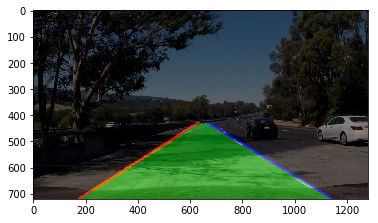

In [14]:
# Display the image 
# Define the Hough transform parameters
rho = 1
theta = np.pi/180
threshold = 50
min_line_len = 50
max_line_gap = 200 
filterWeight = 0.75
hough = houghLaneLines(ROIImage, rho, theta, threshold, min_line_len, max_line_gap)
slopeInt = average(hough)
prev = findEndpoints(image, slopeInt, yLimit)
laneLines = drawLaneLines(image, prev)
result = weightedImage(laneLines, image, α=0.5, β=1., γ=0)
plt.imshow(result)

# Main Pipeline

In [15]:
class DetectLanes:
    def __init__(self):
        self.prev_LaneLines = []
    
    # The video has lot of jitter and lane lines bouncing around due to slight variation in values of the current lane
    # as compared to the previous line. Hence an average of current lane with the previous lanes provide a smoother video output
    def meanLaneLines(self, laneLines, prev_LaneLines):                
        # Add current lane to a list of not NONE
        if laneLines is not None:
            prev_LaneLines.append(laneLines)
        
        # Store 50 most recent lane lines
        if len(prev_LaneLines) >= 50:
            prev_LaneLines.pop(0)
        
        # Average all stored lane lines and the current lane
        if len(prev_LaneLines) > 0:          
            return np.mean(prev_LaneLines, axis = 0, dtype=np.int32)


    def pipeline(self, image):
        
        #Grab the x and y size 
        ysize = image.shape[0]
        xsize = image.shape[1]

        # Define the polygon by vertices
        bottomLeft  = [0, ysize]
        topLeft     = [xsize*0.45, ysize*0.6]
        topRight    = [xsize*0.5, ysize*0.6] 
        bottomRight = [xsize, ysize]
        vertices = np.array([[bottomLeft, topLeft, topRight, bottomRight]], dtype=np.int32)

        # Define the Hough transform parameters
        rho = 1
        theta = np.pi/180
        threshold = 50
        min_line_len = 50
        max_line_gap = 200 

        filterImg = filterWhiteYellow(image)
        gray = grayscale(filterImg)
        blur = gaussianBlur(gray, kernel_size)
        edges = canny(blur, low_threshold, high_threshold)
        roi = regionOfInterest(edges,vertices)
        hough = houghLaneLines(roi, rho, theta, threshold, min_line_len, max_line_gap)
        slopeInt = average(hough)
        #Top endpoint of ROI on the Y axis
        yLimit = int(ysize*0.6) 
        prev = findEndpoints(image, slopeInt, yLimit)
        laneLines = drawLaneLines(image, self.meanLaneLines(prev,self.prev_LaneLines))
        result = weightedImage(laneLines, image, α=0.5, β=1., γ=0.)

        return result

# Run pipeline on all test images

Image Challenge_image1.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


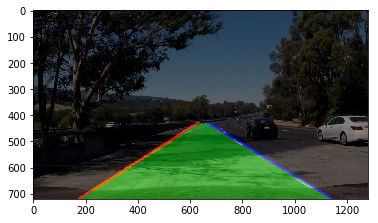

Image Challenge_image2.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


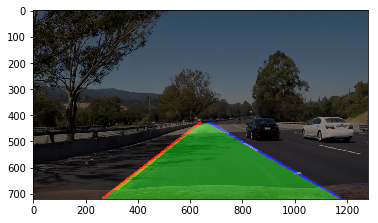

Image solidWhiteCurve.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


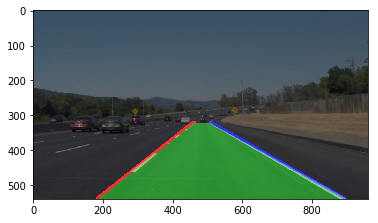

Image solidWhiteRight.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


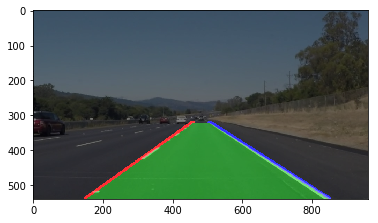

Image solidYellowCurve.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


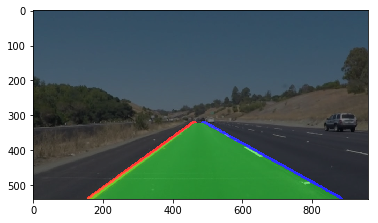

Image solidYellowCurve2.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


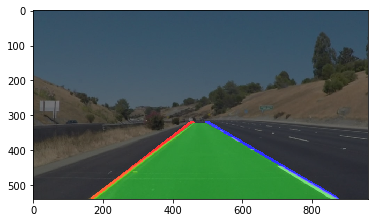

Image solidYellowLeft.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


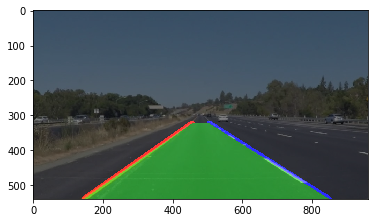

Image whiteCarLaneSwitch.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


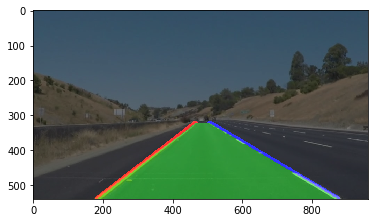

In [16]:
# Create object of the class
detect = DetectLanes()

# Printing out test images
for image_file in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + image_file)
    print('Image ' + image_file +' displayed below is:', type(image), 'with dimensions:', image.shape)
    del detect.prev_LaneLines[:]
    processed_img = detect.pipeline(image)
    mpimg.imsave('test_images_output/Processed_'+ image_file, processed_img)
    plt.imshow(processed_img)
    plt.show()   

# Run pipeline on all test videos

In [17]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

# Flush the previously stored values before adding new lane lines
del detect.prev_LaneLines[:]
white_clip = clip1.fl_image(detect.pipeline) 
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:04<00:00, 45.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 5.23 s


In [18]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

# Flush the previously stored values before adding new lane lines
del detect.prev_LaneLines[:]
yellow_clip = clip2.fl_image(detect.pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:14<00:00, 45.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 15.2 s


In [19]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')

# Flush the previously stored values before adding new lane lines
del detect.prev_LaneLines[:]
challenge_clip = clip3.fl_image(detect.pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:10<00:00, 24.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 10.9 s


In [ ]:
#EXTRA
challenge_output3 = 'test_videos_output_extra/challenge3.mp4'
clip6 = VideoFileClip('test_videos/test_video_full.mp4')

# Flush the previously stored values before adding new lane lines
del detect.prev_LaneLines[:]
challenge_clip3 = clip6.fl_image(detect.pipeline)
%time challenge_clip3.write_videofile(challenge_output3, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output3))

[MoviePy] >>>> Building video test_videos_output_extra/challenge3.mp4
[MoviePy] Writing video test_videos_output_extra/challenge3.mp4


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [00:39<00:09, 25.51it/s]